# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
from collections import Counter
import itertools

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline
from collections import Counter

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
Counter(data['loan_status'])

Counter({'Fully Paid': 702717,
         'Charged Off': 183552,
         'Late (31-120 days)': 19601,
         'Late (16-30 days)': 5448,
         'In Grace Period': 8293,
         'Default': 379,
         'Does not meet the credit policy. Status:Fully Paid': 591,
         'Does not meet the credit policy. Status:Charged Off': 231})

In [7]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data.eval("loan_status == 'Charged Off' or loan_status == 'Default'")

In [8]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [9]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p = [0.7,0.3]
data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )

In [10]:
Counter(data['train'])

Counter({True: 644513, False: 276299})

In [11]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [12]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subset: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [18]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    bestParameters = cv_model.best_params_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    #ouput these two model scores at end of function
    #adjusted for predict probability models by using the best threshold
    accuracyScore = accuracy_score(y_test, y_pred) #return this score for each iteration
    rocAUC = 0 #will be adjusted by following code if model has predict_proba mehtod
    if probs_predicted: 
        rocAUC = roc_auc_score(y_test, y_pred_probs)
    
    if print_to_screen:
        print("Accuracy: ", accuracyScore)
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'params':bestParameters, 'y_pred_labels':y_pred, 
           'accuracy': accuracyScore, 'rocAUC': rocAUC}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [13]:
#ask for all parameters used by called methods
#set random state for each iteration
#get cv_results array from fit_classification call and average /stdev the ouputs across the 100 runs
#pick best setting using this result.
#call fit_classification method 1 more time with only best parameters and get printouts

def hundredSplit_fit_classifier(model,
                                cv_parameters = {}, 
                                model_name = None,
                                random_state = default_seed,
                                data_subset = np.array([True]*len(data)),
                                feature_subset = None,
                                date_range_train = (data.issue_d.min(), data.issue_d.max()),
                                date_range_test = (data.issue_d.min(), data.issue_d.max())):
                                
    topAccScores = [] #stores top score obtained for each train test split
    topAUCScores = [] #stores top score obtained for each train test split
    bestParams = [] #stores top parameters (according to top score) for each train test split
    
    splitCount = 100
    #iterate through 100 random train test splits and store score and parameter results
    for split in range(splitCount):
        #pick new train test split by using new random seed to split data
        np.random.seed(split+1)
        #new random 70 30 train test split
        data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )
        
        #get new train test split with new random state, make sure to carry over dates and data_subset
        data_dictRand = prepare_data(data_subset = data_subset,
                    feature_subset = feature_subset,
                    date_range_train = date_range_train,
                    date_range_test = date_range_test,
                    random_state = default_seed)

        #send train/test split to fit_classification method
        #have method return cv_results best mean score
        modelResults = fit_classification(model, data_dictRand,
                          cv_parameters = cv_parameters,
                          model_name = model_name,
                          random_state = random_state,
                          output_to_file = False,
                          print_to_screen = False)

        #add best score to averages
        topAccScores.append(modelResults['accuracy'])
        topAUCScores.append(modelResults['rocAUC'])
        bestParams.append(tuple(modelResults['params'].values()))

    averageAccuracy = sum(topAccScores)/splitCount
    averageAUC = sum(topAUCScores)/splitCount
    
    #get the parameter settings with the most highest scores
    paramNames = list(modelResults['params'].keys())
    
    #use counter to find the mode. statistics setting will retunr error if multiple
    counter = Counter()
    counter.update(bestParams)
    sortedCounts = sorted(counter.items(), reverse = True, key = lambda x: x[1])
    modeParams = sortedCounts[0][0]
    #modeParams = mode(bestParams)
    bestParamsDict = {paramNames[i]:modeParams[i] for i in range(len(paramNames))}
    
    #print out split results
    if model_name is not None:
        print('Model name:', model_name)
    else:
        print('Model name:', type(model))
    print('best params:', bestParamsDict)
    
    print('\n*** Model Statistics, ' + str(splitCount) + ' train/test splits ***')
    print('Accuracy: ' + str(round(averageAccuracy,5)) + ' +- ' + str(round(np.std(topAccScores),5)))
    #only print AUC scores if they are available
    if averageAUC != 0:
        print('ROC_AUC: ' + str(round(averageAUC,5)) + ' +- ' + str(round(np.std(topAccScores),5)))

    
    
#     print('\n*** Single fit_classifier run with mode of best params ***')
#     fit_classification(model, data_dictRand,
#                           cv_parameters = bestParamsDict,
#                           model_name = model_name,
#                           random_state = random_state,
#                           output_to_file = True,
#                           print_to_screen = True)

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [14]:
## define your set of features to use in different models
your_features = discrete_features + ret_cols + continuous_features  

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [15]:
#trying to check if any nulls: THERE ARE when including continuous_features
print(np.isnan(data_dict['X_train']).any()) 
print(np.isnan(data_dict['X_test']).any()) 
print(np.isnan(data_dict['y_train']).any()) 
print(np.isnan(data_dict['y_test']).any()) 

print(data_dict['X_train'].max())
print(data_dict['X_test'].max())
print(data_dict['y_train'].max())
print(data_dict['y_test'].max())

print(data_dict['X_train'].min())
print(data_dict['X_test'].min())
print(data_dict['y_train'].min())
print(data_dict['y_test'].min())

False
False
False
False
1.0
1.0178704044425115
True
True
0.0
-0.006920697693403113
False
False


In [16]:
#These are the rows where we have NaN in continuous columns
print(len(pd.DataFrame(data_dict['X_train'])[pd.DataFrame(data_dict['X_train']).isnull().any(axis=1)]))
pd.DataFrame(data_dict['X_train'])[pd.DataFrame(data_dict['X_train']).isnull().any(axis=1)]

0


,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56


### Naive Bayes

  Model: Naive Bayes
Fit time: 2.38 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 0.9999999999999627
Accuracy:  0.8011
              precision    recall  f1-score   support

  No default     0.8037    0.9948    0.8891     16032
     Default     0.4684    0.0186    0.0359      3968

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.6361    0.5067    0.4625     20000
weighted avg     0.7372    0.8011    0.7198     20000



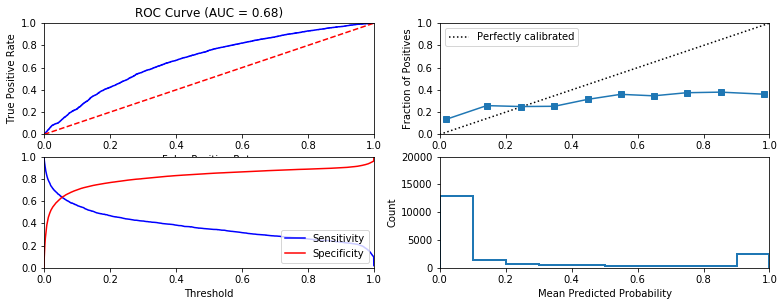


Similarity to LC grade ranking:  0.6912733615235108
Brier score: 0.21629560026682998
Were parameters on edge? : True
Score variations around CV search grid : 48.71155814678001
[0.74896667 0.74543333 0.73453333 0.70303333 0.64933333 0.5752
 0.48573333 0.38413333]


In [19]:
## Train and test a naive bayes classifier
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb = GaussianNB()
gnb = fit_classification(model=gnb,data_dict=data_dict, cv_parameters=cv_parameters,
                         model_name='Naive Bayes', random_state=default_seed)

In [19]:
# >>>>>>>>>>>>>>
# >>>>>>>>>>
# >>>>>>>>>>
# >>>>>>>>>>>
# >>>>>>>>>>>>>>
# >>>>>>>>>>
# >>>>>>>>>>
# >>>>>>>>>>> delete


cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb = GaussianNB()
#
#
hundredSplit_fit_classifier(model=gnb,
                            cv_parameters=cv_parameters,
                            model_name='Naive Bayes', 
                            random_state=default_seed,
                            feature_subset = your_features)

Model name: Naive Bayes
best params: {'var_smoothing': 0.01}

*** Model Statistics, 2 train/test splits ***
Accuracy: 0.80142 +- 0.00032
ROC_AUC: 0.67735 +- 0.00032


### $l_1$ regularized logistic regression

  Model: L1 LogReg
Fit time: 36.56 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.506865491016948
Accuracy:  0.80175
              precision    recall  f1-score   support

  No default     0.8017    1.0000    0.8900     16035
     Default     0.0000    0.0000    0.0000      3965

   micro avg     0.8017    0.8017    0.8017     20000
   macro avg     0.4009    0.5000    0.4450     20000
weighted avg     0.6428    0.8017    0.7135     20000



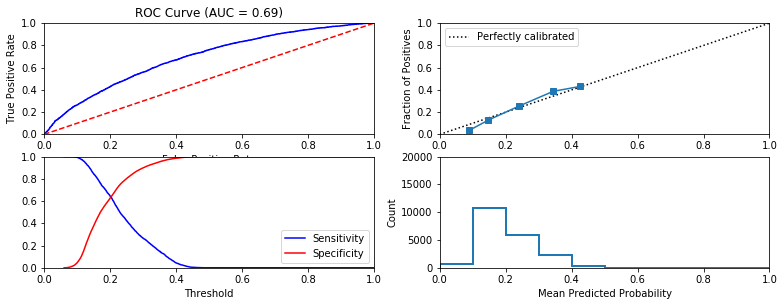


Similarity to LC grade ranking:  0.7116304661360187
Brier score: 0.1484797056556343
Were parameters on edge? : True
Score variations around CV search grid : 0.24100390592537302
[0.8022     0.80026667 0.80206667 0.80196667 0.80193333 0.80176667
 0.80183333 0.8018    ]


In [29]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l1_logistic = fit_classification(model=l1_logistic,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### $l_2$ regularized logistic regression

  Model: L2 LogReg
Fit time: 4.4 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.4415349728224594
Accuracy:  0.8016
              precision    recall  f1-score   support

  No default     0.8081    0.9866    0.8885     16021
     Default     0.5125    0.0565    0.1019      3979

   micro avg     0.8016    0.8016    0.8016     20000
   macro avg     0.6603    0.5216    0.4952     20000
weighted avg     0.7493    0.8016    0.7320     20000



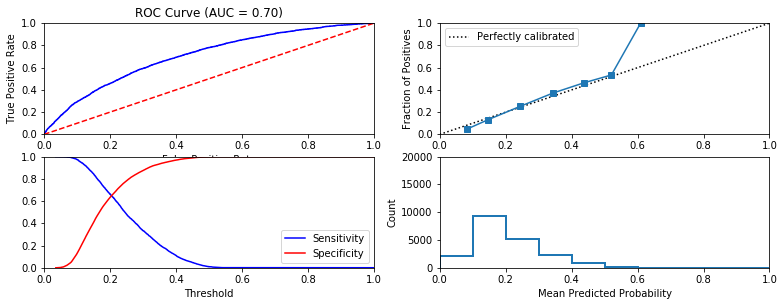


Similarity to LC grade ranking:  0.6802928362835102
Brier score: 0.14629919421671086
Were parameters on edge? : True
Score variations around CV search grid : 0.15382696545129196
[0.80176667 0.801      0.80063333 0.8007     0.80056667 0.80053333
 0.80056667 0.80053333]


In [19]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l2_logistic = fit_classification(model=l2_logistic,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [20]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1
l2_logistic = fit_classification(model=l2_logistic,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.68 seconds
Optimal parameters:
{'alpha': 100.0}

Accuracy:  0.80125
              precision    recall  f1-score   support

  No default     0.8021    0.9981    0.8894     16021
     Default     0.5303    0.0088    0.0173      3979

   micro avg     0.8013    0.8013    0.8013     20000
   macro avg     0.6662    0.5034    0.4534     20000
weighted avg     0.7481    0.8013    0.7159     20000


Similarity to LC grade ranking:  0.6978698861824574


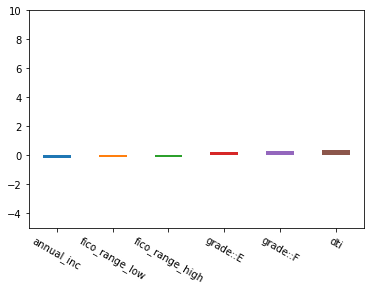

In [21]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 25.61 seconds
Optimal parameters:
{'max_depth': None, 'min_impurity_decrease': 0.00075}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



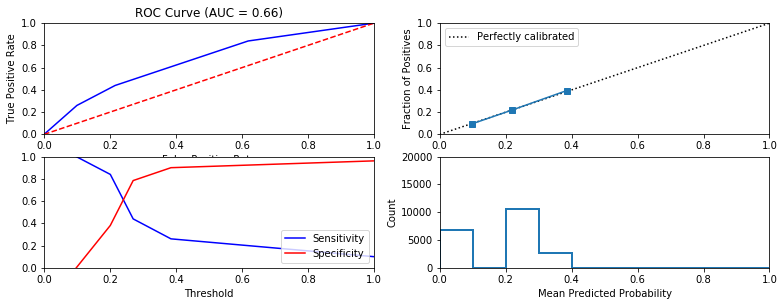


Similarity to LC grade ranking:  0.8383074059080569
Brier score: 0.1499266401188101
Were parameters on edge? : True
Score variations around CV search grid : 13.571725571725572
[0.69286667 0.78196667 0.79723333 0.7974     0.7974     0.80123333
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.79713333 0.79713333 0.7974     0.7974     0.7974     0.80123333
 0.80166667 0.80166667 0.80166667 0.79693333 0.79723333 0.79853333
 0.7974     0.7974     0.80123333 0.80166667 0.80166667 0.80166667
 0.79423333 0.79473333 0.79723333 0.7974     0.7974     0.80123333
 0.80166667 0.80166667 0.80166667 0.7935     0.79483333 0.79723333
 0.7974     0.7974     0.80123333 0.80166667 0.80166667 0.80166667
 0.7879     0.7908 

In [22]:
## Train and test a decision tree classifier
decision_tree = DecisionTreeClassifier()

maxd = [None]
maxd += range(1,11)

cv_parameters = {'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}
decision_tree = fit_classification(model=decision_tree,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="Decision Tree", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

### Random forest

  Model: Random Forest
Fit time: 329.31 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3760706443148564
Accuracy:  0.79935
              precision    recall  f1-score   support

  No default     0.8101    0.9791    0.8866     16021
     Default     0.4733    0.0756    0.1304      3979

   micro avg     0.7994    0.7994    0.7993     20000
   macro avg     0.6417    0.5274    0.5085     20000
weighted avg     0.7431    0.7994    0.7362     20000



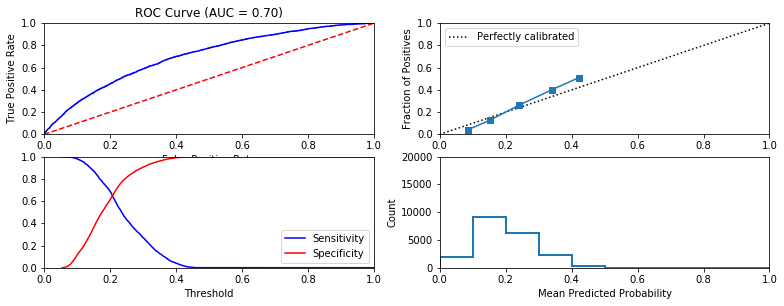


Similarity to LC grade ranking:  0.7881137768916426
Brier score: 0.14743769490922384
Were parameters on edge? : True
Score variations around CV search grid : 0.5155710781256483
[0.7985     0.80163333 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.8017     0.80156667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80136667 0.80136667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.8012     0.8015

In [23]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()

maxd = [None]
maxd += range(1,11)
cv_parameters = {'n_estimators':[50],'criterion':['gini', 'entropy'], 'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}

random_forest = fit_classification(model=random_forest,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="Random Forest", 
                    random_state=default_seed)

# Fit time: 354.89 seconds
# Optimal parameters:
# {'criterion': 'gini', 'max_depth': 9, 'min_impurity_decrease': 0.0, 'n_estimators': 50}
# ROC AUC = 0.7

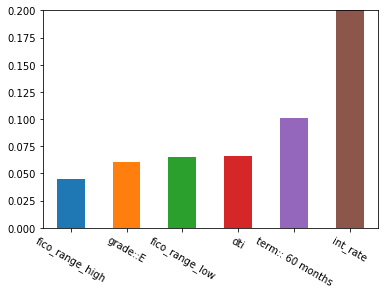

In [24]:
### Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLPerceptron
Fit time: 226.13 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}

Accuracy-maximizing threshold was: 0.4936381736166328
Accuracy:  0.80225
              precision    recall  f1-score   support

  No default     0.8059    0.9921    0.8894     16021
     Default     0.5435    0.0377    0.0705      3979

   micro avg     0.8023    0.8023    0.8023     20000
   macro avg     0.6747    0.5149    0.4799     20000
weighted avg     0.7537    0.8023    0.7264     20000



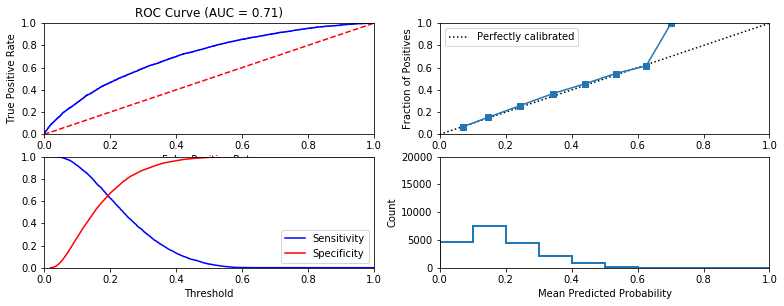


Similarity to LC grade ranking:  0.6945823415613218
Brier score: 0.14552444589372718
Were parameters on edge? : True
Score variations around CV search grid : 7.443931261182538
[0.79993333 0.8005     0.8011     0.80063333 0.7446     0.78236667
 0.74146667 0.7772    ]


In [25]:
## GHAZAL HAS NOT BEEN ABLE TO RUN THIS
## Train and test a multi-layer perceptron classifier
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(25,25,25), (50,50,50), (50,100,50), (100,)],
                 'alpha': [0.01, 0.001, 0.0001, 0.00001],
                 'activation': ['identity', 'logistic', 'tanh', 'relu']}
# cv_parameters = {'hidden_layer_sizes': [(50,50,50), (100,)],
#                  'alpha': [0.01, 0.0001],
#                  'activation': ['identity', 'relu']}
# cv_parameters = {'hidden_layer_sizes':[x for x in itertools.product((10,20,50),repeat=3)], 
#                  'alpha': 10.0 ** -np.arange(2, 6),
#                  'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp = fit_classification(model=mlp,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="MLPerceptron", 
                    random_state=default_seed)

## Train and Test logistic regression model with features derived by LendingClub

  Model: lc1_onlyLC_logistic
Fit time: 0.53 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



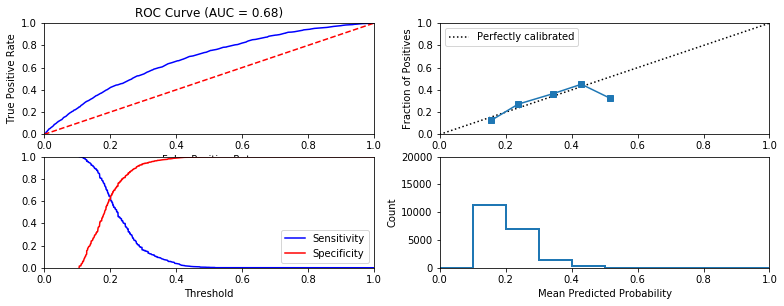


Similarity to LC grade ranking:  0.8603308417715629
Brier score: 0.15107393555249063
Were parameters on edge? : True
Score variations around CV search grid : 0.2577962577962571
[0.80166667 0.80013333 0.7998     0.7996     0.7996     0.7996
 0.7996     0.7996    ]


In [26]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['int_rate']

data_dict2 = prepare_data(feature_subset = a_lendingclub_feature)

lc1_onlyLC_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
lc1_onlyLC_logistic = fit_classification(model=lc1_onlyLC_logistic,data_dict=data_dict2,
                    cv_parameters=cv_parameters,model_name="lc1_onlyLC_logistic", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: lc2_onlyLC_logistic
Fit time: 0.54 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



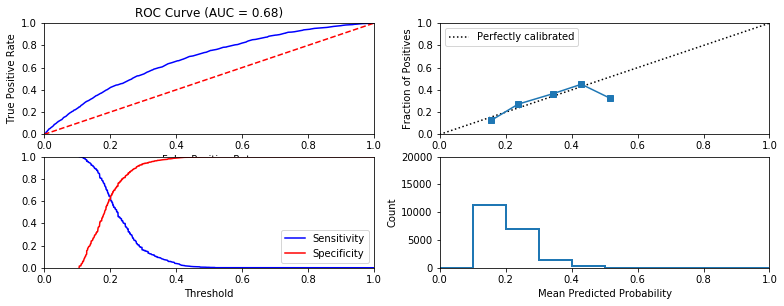


Similarity to LC grade ranking:  0.8603308417715629
Brier score: 0.15107393555249063
Were parameters on edge? : True
Score variations around CV search grid : 0.2577962577962571
[0.80166667 0.80013333 0.7998     0.7996     0.7996     0.7996
 0.7996     0.7996    ]


In [27]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['int_rate']

data_dict2 = prepare_data(feature_subset = a_lendingclub_feature)

lc2_onlyLC_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
lc2_onlyLC_logistic = fit_classification(model=lc2_onlyLC_logistic,data_dict=data_dict2,
                    cv_parameters=cv_parameters,model_name="lc2_onlyLC_logistic", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [28]:
## Train and test a l_2 regularized logistic regression classifier
l2_onlyLC_logistic = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1
l2_onlyLC_logistic = fit_classification(model=l2_onlyLC_logistic,data_dict=data_dict2,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.14 seconds
Optimal parameters:
{'alpha': 100.0}

Accuracy:  0.80025
              precision    recall  f1-score   support

  No default     0.8013    0.9983    0.8890     16021
     Default     0.3000    0.0030    0.0060      3979

   micro avg     0.8003    0.8003    0.8003     20000
   macro avg     0.5506    0.5006    0.4475     20000
weighted avg     0.7015    0.8003    0.7133     20000


Similarity to LC grade ranking:  0.8603308417715629


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [21]:
non_lendingClub_features = set(selected_features).difference({'int_rate', 'grade::B', 'grade::C', 'grade::D',
                                                     'grade::E', 'grade::F', 'grade::G', 'grade::nan'})

# include these features as well???
# 'verification_status::Source Verified, verification_status::Verified, verification_status::nan'


data_dict3 = prepare_data(feature_subset = non_lendingClub_features)

### Naive Bayes - w/o LendingClub features

  Model: Naive Bayes
Fit time: 0.35 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



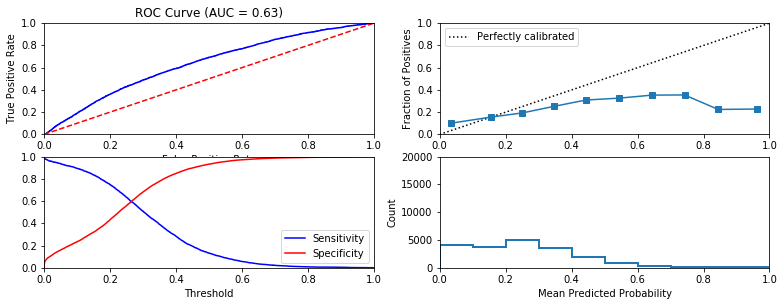


Similarity to LC grade ranking:  0.3538529208597622
Brier score: 0.16729529398917076
Were parameters on edge? : True
Score variations around CV search grid : 0.44505898111739467
[0.77143333 0.76856667 0.76806667 0.768      0.768      0.768
 0.768      0.768     ]


In [30]:
## Train and test a naive bayes classifier
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb_noLC = GaussianNB()
gnb_noLC = fit_classification(model=gnb_noLC,data_dict=data_dict3, cv_parameters=cv_parameters,
                         model_name='Naive Bayes', random_state=default_seed)

In [114]:
#100 train/test split

cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb_noLC = GaussianNB()
hundredSplit_fit_classifier(model=gnb_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Naive Bayes noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Naive Bayes noLC
best params: {'var_smoothing': 0.01}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.80049 +- 0.00278
ROC_AUC: 0.62961 +- 0.00278


### $l_1$ regularized logistic regression  - w/o LendingClub features

  Model: L1 LogReg
Fit time: 7.9 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 0.288523172848969
Accuracy:  0.8015
              precision    recall  f1-score   support

  No default     0.8023    0.9984    0.8897     16035
     Default     0.4444    0.0050    0.0100      3965

   micro avg     0.8015    0.8015    0.8015     20000
   macro avg     0.6234    0.5017    0.4498     20000
weighted avg     0.7314    0.8015    0.7153     20000



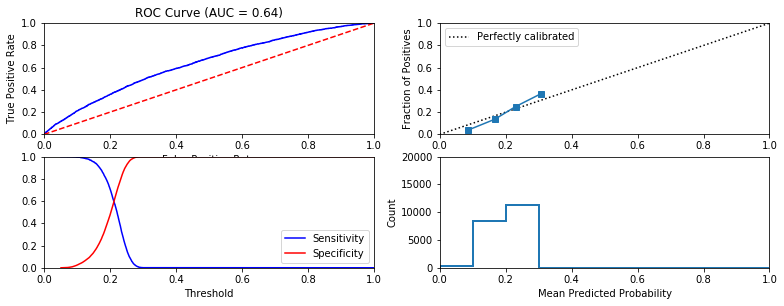


Similarity to LC grade ranking:  0.384086399088177
Brier score: 0.15445338646165138
Were parameters on edge? : True
Score variations around CV search grid : 0.06232859636001695
[0.8022     0.802      0.80176667 0.8017     0.80173333 0.80173333
 0.80173333 0.80173333]


In [49]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic_noLC = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l1_logistic_noLC = fit_classification(model=l1_logistic_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [115]:
#100 train/test split
l1_logistic_noLC = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

hundredSplit_fit_classifier(model=l1_logistic_noLC,
                            cv_parameters=cv_parameters,
                            model_name='L1 LogReg noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: L1 LogReg noLC
best params: {'C': 0.01}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.80043 +- 0.00278
ROC_AUC: 0.63906 +- 0.00278


  Model: L2 LogReg
Fit time: 1.19 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



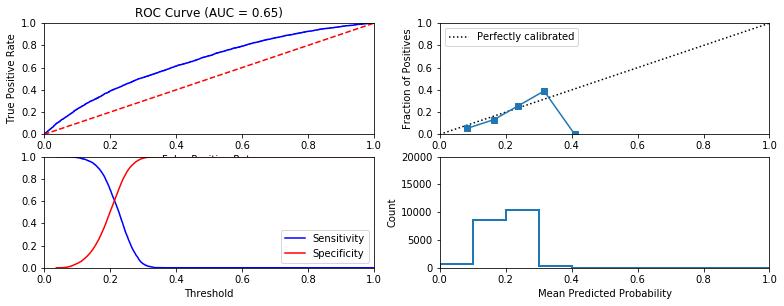


Similarity to LC grade ranking:  0.39130888853891094
Brier score: 0.1534788570760264
Were parameters on edge? : True
Score variations around CV search grid : 0.13721413721413594
[0.80166667 0.80143333 0.80106667 0.80063333 0.80066667 0.8006
 0.8006     0.80056667]


In [32]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l2_logistic_noLC = fit_classification(model=l2_logistic_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [81]:
#
#
#
#
#
#edge result. need to fix this???




#100 train/test split
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.0001,0.001,0.01,0.1,1,5,10,100]}

hundredSplit_fit_classifier(model=l2_logistic_noLC,
                            cv_parameters=cv_parameters,
                            model_name='L2 LogReg noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: L2 LogReg noLC
best params: {'C': 0.0001}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.80046 +- 0.00276
ROC_AUC: 0.50038 +- 0.00276


### $l_2$ regularized logistic regression - w/o LendingClub features

In [33]:
#need to fix these results or use just regular l2
#
#
#
#
#
#
#
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1's C**-1
l2_logistic_noLC = fit_classification(model=l2_logistic_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="Ridge noLC", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: L2 LogReg
Fit time: 0.22 seconds
Optimal parameters:
{'alpha': 100.0}

Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000


Similarity to LC grade ranking:  0.37777188564280695


In [80]:
#100 train/test split
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = RidgeClassifier()

cv_parameters = {'alpha': [i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1's C**-1

hundredSplit_fit_classifier(model=l2_logistic_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Ridge noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Ridge noLC
best params: {'alpha': 100.0}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.8005 +- 0.00278


### Decision tree - w/o LendingClub features

  Model: Decision Tree
Fit time: 14.8 seconds
Optimal parameters:
{'max_depth': None, 'min_impurity_decrease': 0.0005}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80105
              precision    recall  f1-score   support

  No default     0.8011    1.0000    0.8895     16021
     Default     0.0000    0.0000    0.0000      3979

   micro avg     0.8011    0.8011    0.8011     20000
   macro avg     0.4005    0.5000    0.4448     20000
weighted avg     0.6417    0.8011    0.7126     20000



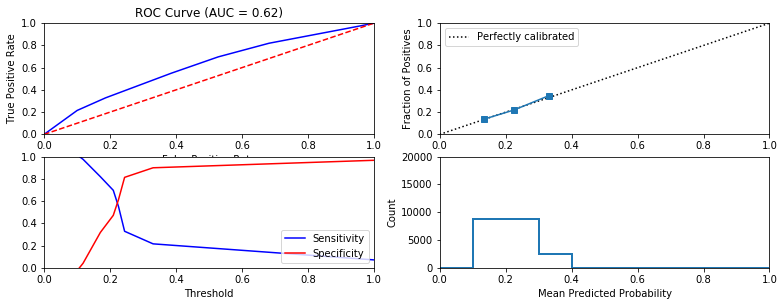


Similarity to LC grade ranking:  0.3106226994563262
Brier score: 0.15464520210731106
Were parameters on edge? : True
Score variations around CV search grid : 14.332640332640333
[0.68676667 0.78206667 0.7981     0.80033333 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80163333 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.79866667 0.79873333 0.8001
 0.80033333 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.79596667 0.7961     0.7994     0.80026667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.79246667 0.79273333 0.79833333
 0.80026667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.7855     0.78796667

In [34]:
## Train and test a decision tree classifier
decision_tree_noLC = DecisionTreeClassifier()

maxd = [None]
maxd += range(1,11)

cv_parameters = {'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}
decision_tree_noLC = fit_classification(model=decision_tree_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="Decision Tree", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [20]:
#100 train/test split
#decision tree model
decision_tree_noLC = DecisionTreeClassifier()

maxd = [None]
maxd += range(1,11,2)

cv_parameters = {'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}

hundredSplit_fit_classifier(model=decision_tree_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Decision Tree noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Decision Tree noLC
best params: {'max_depth': None, 'min_impurity_decrease': 0.000375}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.80051 +- 0.00278
ROC_AUC: 0.61219 +- 0.00278


### Random Forest - w/o LendingClub features

  Model: Random Forest
Fit time: 364.35 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': None, 'min_impurity_decrease': 0.00025, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3316362850087118
Accuracy:  0.80045
              precision    recall  f1-score   support

  No default     0.8035    0.9941    0.8887     16021
     Default     0.4663    0.0209    0.0399      3979

   micro avg     0.8004    0.8004    0.8004     20000
   macro avg     0.6349    0.5075    0.4643     20000
weighted avg     0.7364    0.8004    0.7198     20000



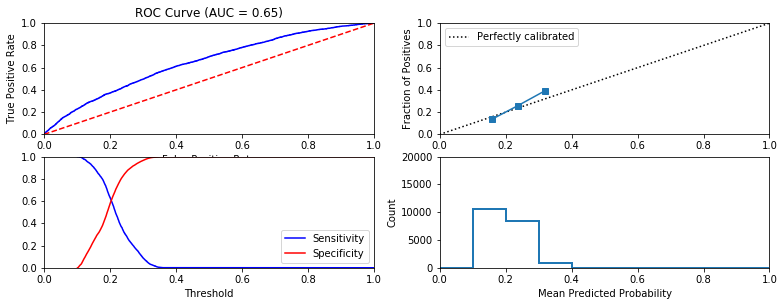


Similarity to LC grade ranking:  0.37871416246197237
Brier score: 0.1532975537696486
Were parameters on edge? : True
Score variations around CV search grid : 0.45322245322244487
[0.79803333 0.80093333 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80166667 0.80166667 0.80166667 0.80163333 0.80163333 0.80166667
 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667 0.80166667
 0.80143333 0.801

In [35]:
## Train and test a random forest classifier

random_forest_noLC = RandomForestClassifier()

maxd = [None]
maxd += range(1,11)
cv_parameters = {'n_estimators':[50],
                 'criterion':['gini', 'entropy'], 
                 'max_depth':maxd, 
                 'min_impurity_decrease':np.linspace(0,0.001,9)}

random_forest_noLC = fit_classification(model=random_forest_noLC,data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="Random Forest", 
                    random_state=default_seed)

In [22]:
#100 train/test split
random_forest_noLC = RandomForestClassifier()

maxd = [None]
maxd += range(1,11,2)
cv_parameters = {'n_estimators':[50],
                 'criterion':['gini', 'entropy'], 
                 'max_depth':maxd, 
                 'min_impurity_decrease':np.linspace(0,0.001,9)}

hundredSplit_fit_classifier(model=random_forest_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Random Forest noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Random Forest noLC
best params: {'criterion': 'gini', 'max_depth': None, 'min_impurity_decrease': 0.000125, 'n_estimators': 50}

*** Model Statistics, 100 train/test splits ***
Accuracy: 0.79374 +- 0.00599
ROC_AUC: 0.65352 +- 0.00599


### Multi-layer perceptron - w/o LendingClub features

  Model: MLPerceptron
Fit time: 203.27 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}

Accuracy-maximizing threshold was: 0.5180032036250116
Accuracy:  0.8006
              precision    recall  f1-score   support

  No default     0.8011    0.9993    0.8892     16021
     Default     0.2000    0.0008    0.0015      3979

   micro avg     0.8006    0.8006    0.8006     20000
   macro avg     0.5005    0.5000    0.4454     20000
weighted avg     0.6815    0.8006    0.7126     20000



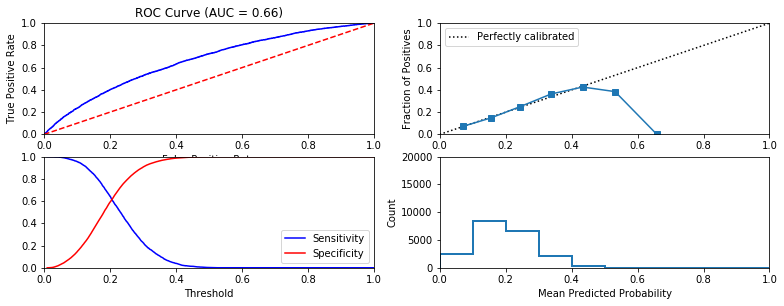


Similarity to LC grade ranking:  0.38590113015674665
Brier score: 0.15116531001902433
Were parameters on edge? : True
Score variations around CV search grid : 1.5848585690515862
[0.8003     0.80116667 0.80133333 0.80043333 0.79226667 0.8011
 0.78863333 0.7999    ]


In [36]:
# GHAZAL IS NOT ABLE TO RUN THIS
## Train and test a multi-layer perceptron classifier
mlp_noLC = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(25,25,25), (50,50,50), (50,100,50), (100,)],
                 'alpha': [0.01, 0.001, 0.0001, 0.00001],
                 'activation': ['identity', 'logistic', 'relu']}
# cv_parameters = {'hidden_layer_sizes': [(50,50,50), (100,)],
#                  'alpha': [0.01, 0.0001],
#                  'activation': ['identity', 'relu']}
# cv_parameters = {'hidden_layer_sizes':[x for x in itertools.product((10,20,50),repeat=3)], 
#                  'alpha': 10.0 ** -np.arange(2, 6),
#                  'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp_noLC = fit_classification(model=mlp_noLC, data_dict=data_dict3,
                    cv_parameters=cv_parameters,model_name="MLPerceptron", 
                    random_state=default_seed)

In [ ]:
#100 train/test split
mlp_noLC = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (100,)],
                 'alpha': [0.01, 0.001, 0.0001, 0.00001],
                 'activation': ['identity', 'logistic', 'relu']}

hundredSplit_fit_classifier(model=mlp_noLC,
                            cv_parameters=cv_parameters,
                            model_name='MLP noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

## Time stability test of YOURMODEL
5. Next you will assess the stability of YourModel over time. To this end, analyze whether YourModel trained (using the Random data splitting procedure in part 2. for cross validation) in 2009 performs worse in 2017 than YourModel trained on more recent data in 2016.

  Model: Time stability test: 2010 trained 2017 tested
Fit time: 1.22 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8824285714285715
              precision    recall  f1-score   support

  No default     0.8824    1.0000    0.9375      6177
     Default     0.0000    0.0000    0.0000       823

   micro avg     0.8824    0.8824    0.8824      7000
   macro avg     0.4412    0.5000    0.4688      7000
weighted avg     0.7787    0.8824    0.8273      7000



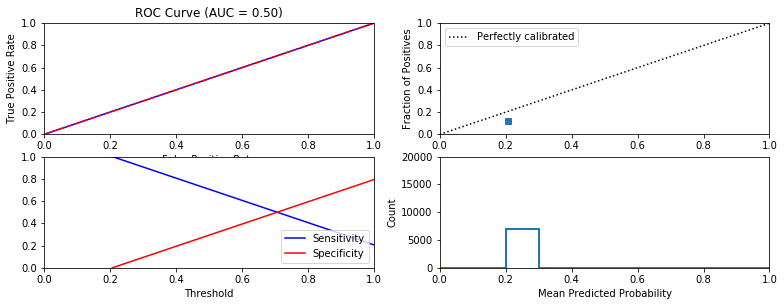


Similarity to LC grade ranking:  nan
Brier score: 0.11170992493277507
Were parameters on edge? : True
Score variations around CV search grid : 1.4893617021276526
[0.88762984 0.88762984 0.88385269 0.87724268 0.87724268 0.87818697
 0.87440982 0.87440982]


{'model': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'params': {'C': 0.01},
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'accuracy': 0.8824285714285715,
 'rocAUC': 0.5,
 'y_pred_probs': array([0.20679887, 0.20679887, 0.20679887, ..., 0.20679887, 0.20679887,
        0.20679887])}

In [19]:
#doesn't work with 2010 data. there is training and test data for 2010. Possible only 1 class of loan outcome in 2010????
#please look into this
#
#
#
#
#




##set YOURMODEL
YOURMODEL = LogisticRegression(penalty='l1')# l1_logistic['model']


## Define the time window of your train and test data
# Total date range of data: 2010-02-01 to 2017-12-01
#training model using 2010 data

start_date_train = datetime.date(year = 2010, month = 1, day = 1)#data.issue_d.min()
end_date_train = datetime.date(year = 2010, month = 12, day = 31)#datetime.date(year = 2010, month = 12, day = 31)

#get predictions for 2017
start_date_test = datetime.date(year = 2017, month = 1, day = 1)
end_date_test = datetime.date(year = 2017, month = 12, day = 31)#data.issue_d.max()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features, random_state=default_seed)

## Train and test YOURMODEL using this data
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
# fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test: 2009 trained 2017 tested", 
#                     cv_parameters =cv_parameters, random_state=default_seed,output_to_file=True,print_to_screen=True)
fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test: 2010 trained 2017 tested", 
                    cv_parameters =cv_parameters, random_state=default_seed,output_to_file=True,print_to_screen=True)

  Model: Time stability test: 2016 trained 2017 tested
Fit time: 8.94 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8797142857142857
              precision    recall  f1-score   support

  No default     0.8797    1.0000    0.9360      6158
     Default     0.0000    0.0000    0.0000       842

   micro avg     0.8797    0.8797    0.8797      7000
   macro avg     0.4399    0.5000    0.4680      7000
weighted avg     0.7739    0.8797    0.8234      7000



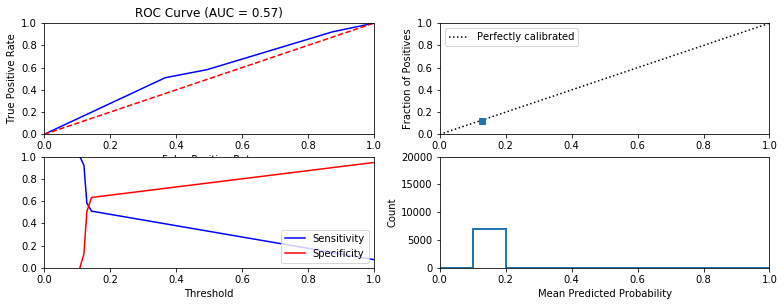


Similarity to LC grade ranking:  0.24117832318056598
Brier score: 0.10534348477836264
Were parameters on edge? : True
Score variations around CV search grid : 0.11336440357727684
[0.88211111 0.88211111 0.88188889 0.88133333 0.88133333 0.88111111
 0.88111111 0.88122222]


{'model': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'params': {'C': 0.01},
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'accuracy': 0.8797142857142857,
 'rocAUC': 0.5693002902969236,
 'y_pred_probs': array([0.12085471, 0.10856561, 0.14399384, ..., 0.14399384, 0.12969895,
        0.12085471])}

In [28]:
#training model using 2016 data
start_date_train = datetime.date(year = 2016, month = 1, day = 1)
end_date_train = datetime.date(year = 2016, month = 12, day = 31)

start_date_train = datetime.date(year = 2017, month = 1, day = 1)
end_date_train = datetime.date(year = 2017, month = 12, day = 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
## Train and test YOURMODEL using this data
fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test: 2016 trained 2017 tested", 
                    cv_parameters =cv_parameters, random_state=default_seed,output_to_file=True,print_to_screen=True)

## Train and test YOURMODEL on the original data

  Model: L1 LogReg
Fit time: 28.62 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.5215352620604025
Accuracy:  0.803
              precision    recall  f1-score   support

  No default     0.8072    0.9908    0.8897     16032
     Default     0.5435    0.0441    0.0816      3968

   micro avg     0.8030    0.8030    0.8030     20000
   macro avg     0.6754    0.5175    0.4856     20000
weighted avg     0.7549    0.8030    0.7293     20000



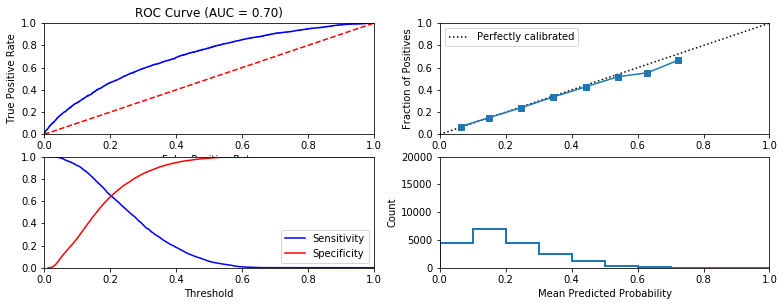


Similarity to LC grade ranking:  0.7478158298551253
Brier score: 0.1455311520860799
Were parameters on edge? : False
Score variations around CV search grid : 0.24979184013322256
[0.7995     0.79866667 0.80023333 0.8005     0.80066667 0.80056667
 0.80056667 0.80066667]


In [29]:
# unsure if we need to train and test the model outside the fit_classification function
# X_train = X[train==True, :]
# X_test = X[train==False, :]
# y_train = y[train==True]
# y_test = y[train==False]


## Train and test a l_1 regularized logistic regression classifier
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}
YOURMODEL = fit_classification(model=YOURMODEL,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="L1 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)


## Test regression models

In [30]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [31]:
#col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

#Trying to just fit my own model manually
X_train = data_dict['X_train']
filter_train = data_dict['train_set']  

X_test = data_dict['X_test']
filter_test = data_dict['test_set']

y_train = data.loc[filter_train, 'ret_OPT'].as_matrix()
y_test = data.loc[filter_test, 'ret_OPT'].as_matrix() 

cv_parameters = {'alpha': [i**-1 for i in [0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1


l1_lr_model = linear_model.Lasso()
cv_model = GridSearchCV(l1_lr_model, cv_parameters, scoring='r2')
cv_model.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [10.0, 1.0, 0.2, 0.1, 0.05, 0.02, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [32]:
print(pd.DataFrame(cv_model.cv_results_)[['mean_train_score', 
                                       'mean_test_score', 
                                        'params']])

   mean_train_score  mean_test_score           params
0               0.0        -0.033712  {'alpha': 10.0}
1               0.0        -0.033712   {'alpha': 1.0}
2               0.0        -0.033712   {'alpha': 0.2}
3               0.0        -0.033712   {'alpha': 0.1}
4               0.0        -0.033712  {'alpha': 0.05}
5               0.0        -0.033712  {'alpha': 0.02}
6               0.0        -0.033712  {'alpha': 0.01}


In [33]:
#Result from manual approach: MATCHES the automated approach, so not something wrong with her code.

In [34]:
#Note to team: these results for l1 and l2 regression don't make much sense as is... not sure why we are getting 
#r-squared scores so close to zero.  the hyperparameter selection doesn't make much sense either.  
#Need to review together 

In [35]:
[i**-1 for i in [0.01,0.1,1,5,10,20,50,100]]

[100.0, 10.0, 1.0, 0.2, 0.1, 0.05, 0.02, 0.01]

In [46]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [i**-1 for i in [0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1

l1_lr_model = linear_model.Lasso()

reg_lasso = fit_regression(model=l1_lr_model, data_dict=data_dict, cv_parameters=cv_parameters,
                           separate=False, model_name="Lasso Regression", random_state=default_seed,
                           output_to_file=True, print_to_screen=True)

  Model: Lasso Regression  Return column: ret_PESS
Fit time: 0.61 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: -1.539474103751104e-09
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.1289805 -0.1289805 -0.1289805 -0.1289805 -0.1289805 -0.1289805
 -0.1289805]
  Model: Lasso Regression  Return column: ret_OPT
Fit time: 0.6 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: -3.6678719084859424e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.04032521 -0.04032521 -0.04032521 -0.04032521 -0.04032521 -0.04032521
 -0.04032521]
  Model: Lasso Regression  Return column: ret_INTa
Fit time: 0.57 seconds
Optimal parameters:
{'alpha': 10.0}

Testing r2 score: -6.327598483846231e-06
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.11618907 -0.11618907 -0.11618907 -0.11618

### $l_2$ regularized linear regressor

In [36]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [i**-1 for i in [0.0001, 0.001,0.01,0.1,1,5,10,20,50,100]]}  #alpha corresponds to L1 C**-1

l2_lr_model = linear_model.Ridge()

reg_ridge = fit_regression(model=l2_lr_model, data_dict=data_dict, cv_parameters=cv_parameters,
                           separate=False, model_name="Ridge Regression", random_state=default_seed,
                           output_to_file=True, print_to_screen=True)

  Model: Ridge Regression  Return column: ret_PESS
Fit time: 1.14 seconds
Optimal parameters:
{'alpha': 1000.0}

Testing r2 score: 0.028402353755721088
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -12.964881058424899
All test scores : [-0.15486972 -0.15030417 -0.15311412 -0.16252766 -0.16780934 -0.16908286
 -0.16940922 -0.1696086  -0.1697432  -0.16979092]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 1.12 seconds
Optimal parameters:
{'alpha': 100.0}

Testing r2 score: 0.02023499897572789
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -29.870995026519942
All test scores : [-0.03119494 -0.02829978 -0.02401994 -0.02475043 -0.02570319 -0.02643342
 -0.02664841 -0.02678145 -0.02687176 -0.02690386]
  Model: Ridge Regression  Return column: ret_INTa
Fit time: 1.26 seconds
Optimal parameters:
{'alpha': 1000.0}

Testing r2 score: 0.032602970759043615
Were parameters on edge (model) : False
Score v

### Multi-layer perceptron regressor

In [49]:
# GHAZAL IS NOT ABLE TO RUN THIS

## trying multi-layer perceptron regression with hyper-parameters
cv_parameters = {'hidden_layer_sizes': [(25,25,25), (50,50,50), (50,100,50), (100,)],
                 'alpha': [0.01, 0.001, 0.0001, 0.00001],
                 'activation': ['identity', 'logistic', 'tanh', 'relu']}
# cv_parameters = {'hidden_layer_sizes':[x for x in itertools.product((10,20,50),repeat=3)], 
#                  'alpha': 10.0 ** -np.arange(2, 6),
#                  'activation': ['identity', 'logistic', 'tanh', 'relu']}
mlp_reg = MLPRegressor()

reg_mlp = fit_regression(model=mlp_reg,data_dict=data_dict,
                    cv_parameters=cv_parameters,model_name="MLPerceptron Regression", 
                    random_state=default_seed,
                    output_to_file=True, print_to_screen=True)

  Model: MLPerceptron Regression  Return column: ret_PESS
Fit time: 28.61 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)}

Testing r2 score: 0.009638448586496318
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -125.78012166069996
All test scores : [-0.10443121 -0.1198891  -0.08195622 -0.10435493 -0.16806891 -0.13041271
 -0.1544568  -0.18504085]
  Model: MLPerceptron Regression  Return column: ret_OPT
Fit time: 36.65 seconds
Optimal parameters:
{'activation': 'identity', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50)}

Testing r2 score: 0.018436413474525626
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -354.91029915001735
All test scores : [-0.02739122 -0.12460549 -0.07197549 -0.03659341 -0.03470165 -0.04310767
 -0.07312112 -0.07771585]
  Model: MLPerceptron Regression  Return column: ret_INTa
Fit time: 33.47 seconds
Optimal parameters:
{'activ

### Random forest regressor

In [53]:
## trying random forest regression with hyper-parameters

# maxd = [None]
# maxd += range(1,11)
# cv_parameters = {'n_estimators':[50],'criterion':['mse', 'mae'], 
#                  'max_depth':maxd, 'min_impurity_decrease':np.linspace(0,0.001,9)}
cv_parameters = {n_estimators': [50, 75, 100, 125, 150, 200], 'max_depth':[5, 10, 20, 30], min_samples_split': [5, 10, 15, 20]} 
# cv_parameters = {n_estimators': [50, 100, 200, 300, 400, 500], 'max_depth':[10, 20, 30, 40, 50, 60]} 

rf_model = RandomForestRegressor()

reg_rf = fit_regression(model=rf_model, data_dict=data_dict, cv_parameters=cv_parameters,
                           separate=False, model_name="Random Forest Regression", random_state=default_seed,
                           output_to_file=True, print_to_screen=True)

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 1547.99 seconds
Optimal parameters:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

Testing r2 score: 0.0545209522291773
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -29.18349724028042
All test scores : [-0.12172011 -0.12297853 -0.12207222 -0.12634038 -0.12018779 -0.12139049
 -0.14119654 -0.13539413 -0.13194496 -0.13568745 -0.13491455 -0.13083735
 -0.1552628  -0.14462473 -0.13949374 -0.14771786 -0.13941626 -0.13572424
 -0.15021437 -0.14403336 -0.13925668 -0.15173169 -0.13980433 -0.13712042]
  Model: Random Forest Regression  Return column: ret_OPT
Fit time: 1576.13 seconds
Optimal parameters:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Testing r2 score: 0.02681877324787807
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -169.68822916408038
All test scores : [-0.03113768 -0.02806526 -0.02646164 -0.02

KeyboardInterrupt: 

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [37]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [54]:
##loop through test investments. 100 train/test
def hundredSplit_test_investments(classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    splitCount = 100
    retPESS = [] #lists to hold the investment return values from each split
    retOPT = []
    retINTa = []
    retINTb = []
    for split in range(splitCount):
        #pick new train test split by using new random seed to split data
        np.random.seed(split+1)
        #new random 70 30 train test split
        data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )
        
        #get new train test split using the new train column created above
        data_dictRand = prepare_data(feature_subset = your_features)
        
        #pass argument to test_invetment method
        strat_returns = test_investments(data_dictRand, classifier = classifier, regressor = regressor, strategy = strategy, 
                              num_loans = num_loans, random_state = random_state, output_to_file = False)
        #save return investment outcomes to lists
        retPESS.append(strat_returns['ret_PESS']['average return'])
        retOPT.append(strat_returns['ret_OPT']['average return'])
        retINTa.append(strat_returns['ret_INTa']['average return'])
        retINTb.append(strat_returns['ret_INTb']['average return'])
    
    #print out average and standard devations of all 100 returns
    print('*** Investment test outcomes - ' + str(splitCount) + ' splits ***')
    print('strategy:',test_strategy)   
    print('ret_PESS: ', round(sum(retPESS)/splitCount,7), '+-', round(np.std(retPESS),7))
    print('ret_OPT: ', round(sum(retOPT)/splitCount,7), '+-', round(np.std(retOPT),7))
    print('ret_INTa: ', round(sum(retINTa)/splitCount,7), '+-', round(np.std(retINTa),7))
    print('ret_INTb: ', round(sum(retINTb)/splitCount,7), '+-', round(np.std(retINTb),7))

In [39]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_ridge, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.004058544988705338
ret_OPT: 0.047961352339605294
ret_INTa: 0.01146923236893978
ret_INTb: 0.05679786271543351


In [55]:
# 100 investment splits
test_strategy = 'Random'

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_ridge, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Random
ret_PESS:  0.0035759 +- 0.0026607
ret_OPT:  0.0451737 +- 0.0036963
ret_INTa:  0.0101699 +- 0.0018351
ret_INTb:  0.0559832 +- 0.0021784


In [40]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(dclassifier = YOURMODEL, regressor = reg_ridge, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.01849092882361219
ret_OPT: 0.04424637933479139
ret_INTa: 0.008447388612852632
ret_INTb: 0.05357088896408533


In [56]:
# 100 investment splits
test_strategy = 'Default-based'

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_ridge, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Default-based
ret_PESS:  0.0067495 +- 0.0029207
ret_OPT:  0.0452265 +- 0.0039215
ret_INTa:  0.0107098 +- 0.0019619
ret_INTb:  0.055174 +- 0.0022096


In [41]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_ridge, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.024599429626051186
ret_OPT: 0.035583036998821774
ret_INTa: 0.011144636088754928
ret_INTb: 0.05518791470948758


In [57]:
# 100 investment splits
test_strategy = 'Return-based'

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_ridge, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Return-based
ret_PESS:  0.009629 +- 0.0030374
ret_OPT:  0.0446196 +- 0.0035395
ret_INTa:  0.0111122 +- 0.0020218
ret_INTb:  0.0570637 +- 0.0021984


In [42]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'alpha': [i**-1 for i in [0.0001, 0.001,0.01,0.1,1,5,10,20,50,100]]}

reg_separate = fit_regression(model=l2_lr_model, data_dict=data_dict, cv_parameters=cv_parameters,
                           separate=True, model_name="Ridge Regression", random_state=default_seed,
                           output_to_file=True, print_to_screen=True)

print('\nstrategy:',test_strategy)
strat_defret = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_separate, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

  Model: Ridge Regression  Return column: ret_PESS
Fit time: 0.68 seconds
Optimal parameters:
model_0: {'alpha': 100.0} model_1 {'alpha': 100.0}

Testing r2 scores:
model_0: 0.06051637962096246
model_1: 0.11305398221912233
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -25.25087039826965
All test scores : [-0.41778798 -0.37426979 -0.35989103 -0.40480789 -0.44098077 -0.44757213
 -0.44898509 -0.44988712 -0.45052996 -0.45076665]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -31.995296476141572
All test scores : [-0.39246001 -0.32361098 -0.29732878 -0.31506028 -0.35140993 -0.36282881
 -0.36456774 -0.36544428 -0.36595531 -0.36611844]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 0.69 seconds
Optimal parameters:
model_0: {'alpha': 10.0} model_1 {'alpha': 100.0}

Testing r2 scores:
model_0: 0.22837082308077217
model_1: 0.10740000620881884
Were parameters on edge (model_0) : False
Score v

In [58]:
#100 test investment splits
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'alpha': [i**-1 for i in [0.0001, 0.001,0.01,0.1,1,5,10,20,50,100]]}

reg_separate = fit_regression(model=l2_lr_model, data_dict=data_dict, cv_parameters=cv_parameters,
                           separate=True, model_name="Ridge Regression", random_state=default_seed,
                           output_to_file=True, print_to_screen=False)

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_separate, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Default-return-based
ret_PESS:  0.0170178 +- 0.0024302
ret_OPT:  0.0448117 +- 0.0033212
ret_INTa:  0.0114469 +- 0.0018943
ret_INTb:  0.0552007 +- 0.0025261


## Sensitivity test of portfolio size

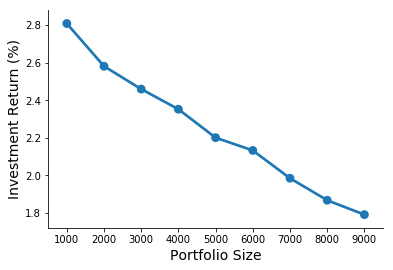

In [63]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_separate, strategy = 'Default-return-based', 
                              num_loans = num_loans, random_state = default_seed,output_to_file = True)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()